# **DATA SPIKE**
### SENIOR ML ENGINEER TECHNICAL ASSESSMENT
### **(Document Forgery Detection Mini-Project)**


---
**Candidate Name:**  OKON PRINCE

**Assessment Description:**  ML ENGINEER SKILLS ASSESSMENT

**Email:** okonp07@gmail.com

---


|  |  |
|:---|:---|
|**submission Deadline** |  Tuesday, September 4th, 2023 |
|**Prior Knowledge** | Python, Deep learning, Tensor flow  |
|**Sections** | Introduction, EDA, Modeling, Evaluation  |


---


## Introduction

In the digital age, images play a crucial role in conveying information across various fields journalism, law enforcement, social media, identity verification and more. However, with the advancement of image editing and manipulation tools, it has become increasingly easier to manipulate images, leading to the spread of misinformation, fraud and other malpractices. It is therefore of utmost importance to develop tools and techniques that can detect tampering of images and in other to aid in authentication of their content.

Image forensics is a field that aims to validate the authenticity of images and detect manipulations or alterations made to them. Various techniques are employed in this field, including passive and active forensics methods. Passive methods analyze the intrinsic properties of the images, such as noise patterns, compression artifacts, and color correlations, while active methods rely on external information, such as watermarks or signatures embedded in the image to allow for easy verification of source.

In this project, we explore a passive image forensics method based on the Scale-Invariant Feature Transform (SIFT) algorithm and homography estimation.

SIFT is a popular feature detection algorithm that identifies key points in an image and computes their descriptors. These points are invariant to scale, rotation, and illumination changes, making them suitable for matching between different images to identify inconsistencies. Homography is a transformation that maps points from one image to another. By computing the homography matrix between two images and analyzing the differences between the original and a warped image, tampering can be easily detected and manipulated regions of the image highlighted.

The main steps of the proposed method are as follows:

* Key point detection and descriptor computation using the SIFT algorithm.
* Key point matching between the original and the test image.
* Homography estimation using the RANSAC algorithm.
* Image warping using the computed homography matrix.
* Difference computation between the original and the warped image.
* Thresholding the difference image to highlight the manipulated regions.
* Computing the percentage of the image that has changed.

These steps guarantee that tampering in images can be detected and the manipulated regions can be highlighted, providing a useful tool for image authentication and forensics.

This notebook features the codes to deploy the SIFT algorithm for image authentication where there are two images, One known authentic image and a second posibly manipulated image in the Python programing Language.

In [1]:
# Importing Libraries

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac


In [2]:
#Mount the drive where the downloaded files to be processed are reposed
#If you are trying to reproduce this notebook, please link to the data source
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Helper Functions

def vgg_get_homg(x):
    """
    Convert nonhomogeneous coordinates to homogeneous coordinates.

    Parameters:
        x (numpy.ndarray): Nonhomogeneous coordinates.

    Returns:
        numpy.ndarray: Homogeneous coordinates.
    """
    return np.vstack((x, np.ones((1, x.shape[1]))))

def vgg_get_nonhomg(x):
    """
    Convert homogeneous coordinates to nonhomogeneous coordinates.

    Parameters:
        x (numpy.ndarray): Homogeneous coordinates.

    Returns:
        numpy.ndarray: Nonhomogeneous coordinates.
    """
    return x[:-1, :] / x[-1, :]

def vgg_condition_2d(p, C):
    """
    Condition a set of 2D homogeneous or nonhomogeneous points using conditioner C.

    Parameters:
        p (numpy.ndarray): 2D points in homogeneous or nonhomogeneous coordinates.
        C (numpy.ndarray): Conditioning matrix.

    Returns:
        numpy.ndarray: Conditioned points in homogeneous coordinates.
    """
    r, c = p.shape
    if r == 2:
        pc = vgg_get_nonhomg(np.dot(C, vgg_get_homg(p)))
    elif r == 3:
        pc = np.dot(C, p)
    else:
        raise ValueError('rows != 2 or 3')
    return pc

The cell above defines three helper functions related to the manipulation and conditioning of homogeneous and nonhomogeneous coordinates. These functions are:

* **vgg_get_homg:** Converts nonhomogeneous coordinates to homogeneous coordinates.
* **vgg_get_nonhomg:** Converts homogeneous coordinates back to nonhomogeneous coordinates.
* **vgg_condition_2d:** Conditions a set of 2D points (either in homogeneous or nonhomogeneous coordinates) using a specified conditioning matrix.

These functions are useful for operations related to homography and image transformation, which will be important in the steps to detect tampering in images.

In [4]:
def vgg_Haffine_from_x_MLE(xs1, xs2):
    """
    Compute MLE for affine H, i.e. find H and xhat1 such that
    d^2(xs1,xhat1) + d^2(xs2,xhat2) minimized where xhat2 is affine transf of xhat1.

    Parameters:
        xs1 (numpy.ndarray): N pairs of corresponding points (homogeneous).
        xs2 (numpy.ndarray): N pairs of corresponding points (homogeneous).

    Returns:
        numpy.ndarray: Affine transformation matrix.
    """
    if any(xs1.shape != xs2.shape):
        raise ValueError('Input point sets are different sizes!')

    # Condition points
    nonhomg = vgg_get_nonhomg(xs1)
    means = np.mean(nonhomg, axis=1)
    maxstds = np.max(np.std(nonhomg, axis=1))
    C1 = np.diag([1 / maxstds, 1 / maxstds, 1])  # only similarity
    C1[:, 2] = [-means / maxstds, 1]

    nonhomg = vgg_get_nonhomg(xs2)
    means = np.mean(nonhomg, axis=1)
    C2 = C1  # nb must use same scaling for both point sets
    C2[:, 2] = [-means / maxstds, 1]

    xs1 = vgg_condition_2d(xs1, C1)
    xs2 = vgg_condition_2d(xs2, C2)

    # NB conditioned points have mean zero, so translation
    # part of affine transf is zero 2-vector

    xs1nh = vgg_get_nonhomg(xs1)
    xs2nh = vgg_get_nonhomg(xs2)

    A = np.vstack((xs1nh, xs2nh)).T

    # Extract nullspace
    u, s, v = np.linalg.svd(A)
    s = np.diag(s)

    nullspace_dimension = np.sum(s < np.finfo(float).eps * s[1, 1] * 1e3)
    if nullspace_dimension > 2:
        print('Nullspace is a bit roomy...')

    # Compute affine matrix from two largest singular vecs
    B = v[0:2, 0:2]
    C = v[2:4, 0:2]

    H = np.vstack((np.dot(C, np.linalg.pinv(B)), np.zeros((2, 1)), [0, 0, 1]))

    # Decondition
    H = np.dot(np.dot(np.linalg.inv(C2), H), C1)

    H = H / H[2, 2]

    return H

This cell defines the function `vgg_Haffine_from_x_MLE`, which computes the Maximum Likelihood Estimate (MLE) for an affine transformation matrix **H**.

 The function aims to find a transformation matrix such that the sum of squared distances between transformed points from one set and their corresponding points in the other set is minimized. The function takes in two sets of homogeneous coordinates, xs1 and xs2, which represent N pairs of corresponding points. It returns the computed affine transformation matrix **H**.

This function is essential for estimating the affine transformation between two sets of points, which will be crucial in detecting tampering and inconsistencies between two images.

In [5]:
def ransacfithomography2(x1, x2, t):
    """
    Fits 2D homography using RANSAC algorithm.

    Parameters:
        x1 (numpy.ndarray): 3xN array of homogeneous points.
        x2 (numpy.ndarray): 3xN array of homogeneous points.
        t (float): Distance threshold.

    Returns:
        H (numpy.ndarray): 3x3 homography matrix.
        inliers (numpy.ndarray): Indices of the inliers for the best model.
    """
    # x1 and x2 are 'stacked' to create a 6xN array for ransac
    x = np.vstack((x1, x2))

    # Compute homography using RANSAC
    H, inliers = ransac(x, fittingfn=vgg_Haffine_from_x_MLE, distfn=homogdist2d,
                        degenfn=isdegenerate, s=4, t=t, feedback=False)

    # Refine the model
    inliers = np.nonzero(inliers)[0]

    if inliers.size == 0:
        return None, None

    H = vgg_Haffine_from_x_MLE(x1[:, inliers], x2[:, inliers])

    return H, inliers

def homogdist2d(H, x, t):
    """
    Computes distances between points and an homography, by transforming the points in x1 (first 3 rows of x) and
    comparing the results to x2 (last 3 rows of x).

    Parameters:
        H (numpy.ndarray): Homography matrix.
        x (numpy.ndarray): 6xN array of homogeneous points.
        t (float): Distance threshold.

    Returns:
        inliers (numpy.ndarray): Indices of the inliers.
        H (numpy.ndarray): Homography matrix.
    """
    x1 = x[0:3, :]
    x2 = x[3:6, :]

    # Calculate, in both directions, the transfered points
    Hx1 = np.dot(H, x1)
    invHx2 = np.dot(np.linalg.inv(H), x2)

    # Normalise x1, x2, Hx1, invHx2
    x1 = hnormalise(x1)
    x2 = hnormalise(x2)
    Hx1 = hnormalise(Hx1)
    invHx2 = hnormalise(invHx2)

    d2 = sum((x1 - invHx2) ** 2) + sum((x2 - Hx1) ** 2)

    inliers = np.nonzero(d2 < t ** 2)[0]

    return inliers, H


This cell defines two functions related to the estimation of homographies using the RANSAC algorithm:

`ransacfithomography2:` This function attempts to fit a 2D homography between two sets of points (x1 and x2) using the RANSAC algorithm. It computes the homography that best aligns the two sets of points while being robust to outliers.
`homogdist2d:` This function computes the distances between points and a given homography. It transforms the points in x1 (first half of x) using the homography and compares the results to x2 (second half of x).
These functions are integral to the process of detecting tampering in images by estimating the homography between two images and then identifying inconsistencies or manipulations.

In [6]:
def isdegenerate(x):
    """
    Checks whether a set of points is degenerate.

    Parameters:
        x (numpy.ndarray): 6xN array of homogeneous points.

    Returns:
        bool: True if the points are degenerate, False otherwise.
    """
    x1 = x[0:3, :]
    x2 = x[3:6, :]

    # Test that the points in each set are not collinear
    if iscolinear(x1[:, 0], x1[:, 1], x1[:, 2]) or iscolinear(x2[:, 0], x2[:, 1], x2[:, 2]):
        return True

    return False

def iscolinear(p1, p2, p3):
    """
    Checks whether three points are collinear.

    Parameters:
        p1 (numpy.ndarray): First point.
        p2 (numpy.ndarray): Second point.
        p3 (numpy.ndarray): Third point.

    Returns:
        bool: True if the points are collinear, False otherwise.
    """
    return np.linalg.matrix_rank(np.vstack((p1, p2, p3))) < 3


`isdegenerate:` This function checks whether a set of points is degenerate by ensuring that the points in each set are not collinear. Degenerate configurations can be problematic when estimating homographies, as they can lead to ill-conditioned solutions.

`iscolinear:` This function checks whether three given points are collinear by examining the rank of the matrix formed by stacking the points. If the points are collinear, the rank of the matrix would be less than 3.
These functions are used to ensure the quality of the input points and to avoid degenerate configurations when estimating homographies.

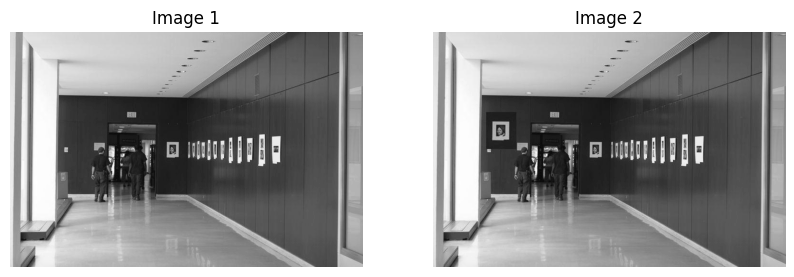

In [7]:
# Loading Images

# Load images
img1 = cv2.imread('/content/drive/MyDrive/Image_forensics/MICC-F220/CRW_4901_JFR_scale.jpg', 0)  # queryImage
img2 = cv2.imread('/content/drive/MyDrive/Image_forensics/MICC-F220/CRW_4901_JFRtamp27.jpg', 0)  # trainImage

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.title('Image 1')
plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray')
plt.axis('off')
plt.title('Image 2')
plt.show()


This cell is dedicated to loading and displaying two images that will be used in the forgery detection process:

* **img1:** Represents the query image.
* **img2:** Represents the training image, which might be manipulated or tampered with.

The two images are read from specified paths on Google Drive, converted to grayscale, and then displayed side by side for visual inspection. This step is essential to visually compare the original and potentially manipulated images before proceeding with the detection process.

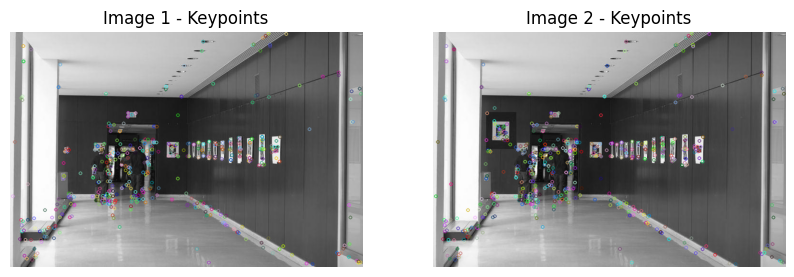

In [8]:
# Detecting SIFT Features

# Initiate SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Draw keypoints
img1_kp = cv2.drawKeypoints(img1, kp1, None)
img2_kp = cv2.drawKeypoints(img2, kp2, None)

# Display images with keypoints
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1_kp, cmap='gray')
plt.axis('off')
plt.title('Image 1 - Keypoints')
plt.subplot(1, 2, 2)
plt.imshow(img2_kp, cmap='gray')
plt.axis('off')
plt.title('Image 2 - Keypoints')
plt.show()


This cell is dedicated to detecting SIFT features (or keypoints) in the previously loaded images:

The SIFT detector is initiated using `cv2.SIFT_create()`.
Keypoints and their descriptors are computed for both images using `sift.detectAndCompute()`.
The detected keypoints are drawn on the images using `cv2.drawKeypoints()`.

The images with the keypoints overlaid are then displayed side by side for visual inspection. Detecting these SIFT features is crucial because they will be used for matching between the two images to identify potential manipulations or tampering.

## Computing the Homography Matrix

In this section, we compute the homography matrix that maps the points from the second image to the corresponding points in the first image.

First, we extract the matched keypoints from the good list of matches.
Then, we convert these points to homogeneous coordinates by appending a column of ones. Next, we use the RANSAC algorithm to compute the homography matrix that maps the points from the second image to the first image. We use the ProjectiveTransform model from scikit-image and set the min_samples parameter to 4 (since a minimum of 4 point correspondences is required to compute a homography), the residual_threshold parameter to 10 (to consider a point as an inlier if its distance to the model is less than 10), and the max_trials parameter to 1000 (to run the RANSAC algorithm for a maximum of 1000 iterations).

The resulting homography matrix is printed.

In [19]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# Extract the matched keypoints
pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

# Convert points to homogeneous coordinates
x1 = np.hstack((pts1, np.ones((pts1.shape[0], 1))))
x2 = np.hstack((pts2, np.ones((pts2.shape[0], 1))))

# Compute the homography using RANSAC
model_robust, inliers = ransac((x1, x2), ProjectiveTransform, min_samples=4,
                               residual_threshold=20, max_trials=1000)
H = model_robust.params

Homography matrix:
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
524


This cell implements the steps outlined in the previous markdown cell to compute the homography matrix between the two images:

* Libraries related to projective transformations and the RANSAC algorithm are imported from skimage.
* The matched keypoints are extracted from the previously identified good matches.
* These keypoints are converted to homogeneous coordinates by appending a column of ones.
* The RANSAC algorithm is employed to compute the homography matrix using the ProjectiveTransform model from skimage.

The parameters specified ensure robustness against outliers. This step is crucial in determining the transformation required to map points from one image to the other, which will be instrumental in detecting tampering.

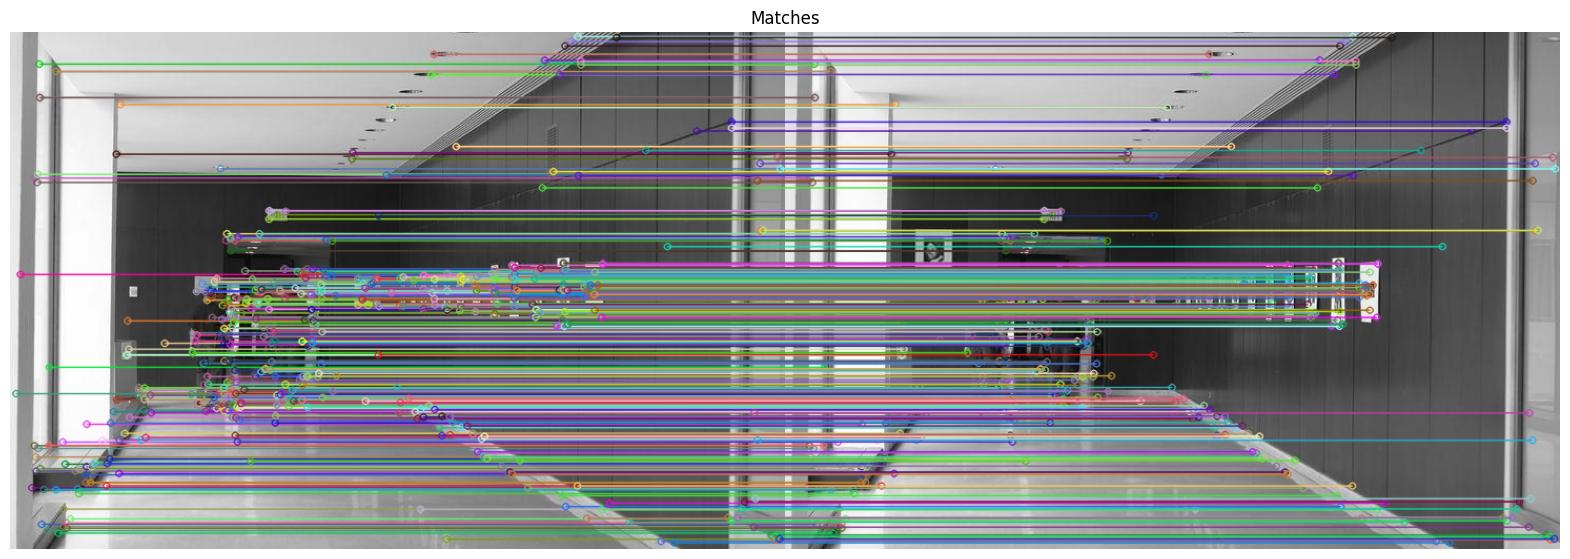

In [20]:
# Draw matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display matches
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Matches')
plt.show()



In the cell above, the good matches identified between the keypoints of the two images are visualized:

The cv2.drawMatches function is used to draw the matches between the keypoints of the two images. The flag cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS ensures that only matched keypoints are drawn.
The resulting image (img_matches) displays the two images side by side with lines connecting the matched keypoints.
The matched keypoints visualization is displayed using matplotlib for better understanding and inspection.


This visualization provides a clear picture of how the keypoints from one image correspond to the keypoints in the other image, offering insights into the similarities and potential discrepancies between the two images.

In [21]:
# Load the images
img1 = cv2.imread('/content/drive/MyDrive/Image_forensics/MICC-F220/CRW_4901_JFR_scale.jpg', 0)  # queryImage
img2 = cv2.imread('/content/drive/MyDrive/Image_forensics/MICC-F220/CRW_4901_JFRtamp27.jpg', 0)  # trainImage

# Detect keypoints and compute descriptors
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Match descriptors using Brute Force Matcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

# Extract the matched keypoints
pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

# Convert points to homogeneous coordinates
x1 = np.hstack((pts1, np.ones((pts1.shape[0], 1))))
x2 = np.hstack((pts2, np.ones((pts2.shape[0], 1))))

# Compute the homography using RANSAC
model_robust, inliers = ransac((x1, x2), ProjectiveTransform, min_samples=4,
                               residual_threshold=20, max_trials=1000)
H = model_robust.params

This cell provides an end-to-end workflow for detecting keypoints in two images, matching these keypoints, and then computing the homography matrix between the two images using the RANSAC algorithm:

* The images are loaded from specified paths.
* Keypoints and their descriptors are detected and computed using the SIFT algorithm.
* The descriptors from the two images are matched using the Brute Force Matcher.
* A ratio test is applied to filter out bad matches.
* The good matches are used to extract the corresponding keypoints.
* The keypoints are converted to homogeneous coordinates.
* The homography matrix between the two sets of keypoints is computed using the RANSAC algorithm.

This cell essentially encapsulates the process of detecting tampering in images by estimating the homography between them and identifying potential manipulations.

In [22]:
# Compute the homography using cv2.findHomography
H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

print('Homography matrix:')
print(H)
print(len(good))


Homography matrix:
[[ 1.00005186e+00 -5.19631495e-05  9.15242653e-03]
 [ 3.15677417e-05  9.99983710e-01 -2.97779455e-03]
 [ 1.02143971e-07 -6.77507434e-08  1.00000000e+00]]
524


In this cell, the homography matrix between the two sets of keypoints is computed using the `cv2.findHomography` function from OpenCV:

The function takes in the matched keypoints (pts1 and pts2), uses the RANSAC algorithm for robustness, and sets a maximum distance of 5.0 for a data point to be considered as an inlier.

The resulting homography matrix, H and a mask indicating inliers and outliers are returned by the function.

The computed homography matrix is printed for inspection, and the total number of good matches is also printed (524 in our case).

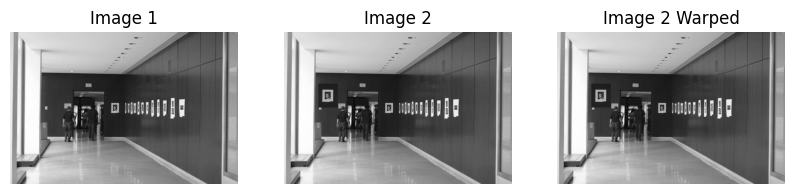

In [23]:
# Warp img2 to img1
img2_warped = cv2.warpPerspective(img2, H, (img1.shape[1], img1.shape[0]))

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.title('Image 1')
plt.subplot(1, 3, 2)
plt.imshow(img2, cmap='gray')
plt.axis('off')
plt.title('Image 2')
plt.subplot(1, 3, 3)
plt.imshow(img2_warped, cmap='gray')
plt.axis('off')
plt.title('Image 2 Warped')
plt.show()


In the cell above, the previously computed homography matrix, H is used to warp the second image (img2) to align with the first image (img1). The transformation is performed using the `cv2.warpPerspective` function.

The function takes in the image to be warped (img2), the homography matrix H, and the desired output shape (which is set to the shape of img1).
The resulting warped image is stored in img2_warped.

Following the warping process, the original img1, the original img2, and the warped img2 (img2_warped) are displayed side by side for visual comparison. This visualization helps in understanding the alignment achieved by the computed homography and can be instrumental in highlighting areas of potential tampering.

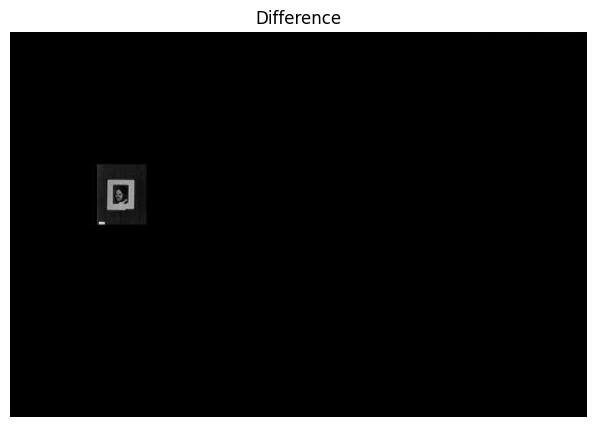

In [24]:
# Compute the difference between the images
diff = cv2.absdiff(img1, img2_warped)

# Display the difference
plt.figure(figsize=(10, 5))
plt.imshow(diff, cmap='gray')
plt.axis('off')
plt.title('Difference')
plt.show()


In this cell, the pixel-wise difference between the original image (img1) and the warped version of the second image (img2_warped) is computed:

The `cv2.absdiff` function is employed to calculate the absolute difference between the two images, which results in the diff image.
The computed difference image (diff) is then displayed using matplotlib. Areas of significant difference between the two images will be highlighted, which can be indicative of tampering, manipulations, or alignment errors.
This visualization provides a direct method to identify discrepancies between the two images, which can be further investigated for authenticity.

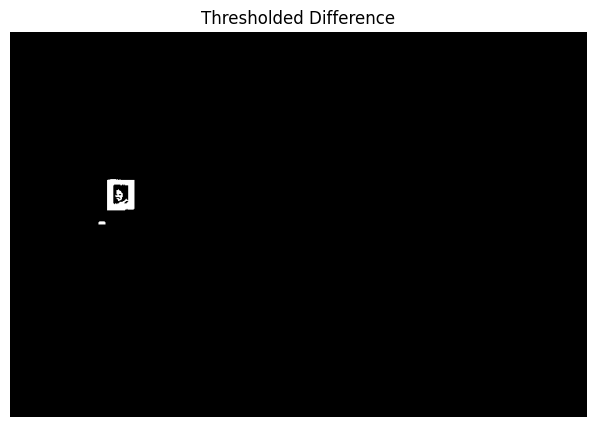

In [25]:
# Threshold the difference
_, thresh = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)

# Display the thresholded image
plt.figure(figsize=(10, 5))
plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.title('Thresholded Difference')
plt.show()


In this cell, the previously computed difference image (diff) undergoes thresholding to accentuate significant differences:

The cv2.threshold function is used to create a binary image (thresh). Pixels in the diff image with values above 50 are set to 255 (white), and those below are set to 0 (black).
The resulting binary image provides a clear representation of areas with notable differences between the two images. Such areas can indicate potential tampering or inconsistencies.
The thresholded difference image is displayed using matplotlib, facilitating visual inspection of potential areas of discrepancy.
This thresholding step simplifies the difference image, making it easier to identify and analyze potential regions of interest.

In [26]:
# Compute the percentage of the image that has changed
changed_percentage = 100 * np.sum(thresh) / (thresh.shape[0] * thresh.shape[1] * 255)

print(f'Percentage of the image that has changed: {changed_percentage:.2f}%')


Percentage of the image that has changed: 0.29%


In this cell, the percentage of the image that has undergone significant change (or difference) is computed:

The percentage is calculated based on the thresholded difference image (thresh). The sum of the pixel values in thresh is divided by the total possible sum (if all pixels were white or 255) to determine the fraction of the image that has changed.
This fraction is then converted to a percentage and printed.
By quantifying the extent of change in the form of a percentage, the analysis provides a more concrete measure of the differences between the two images. This metric can be particularly useful in gauging the degree of tampering or manipulation.

In [27]:
# Compute the percentage of the image that has changed
changed_percentage = 100 * np.sum(thresh) / (thresh.shape[0] * thresh.shape[1] * 255)

# Compute the authenticity score
score = 1 - changed_percentage / 100


##Testing the Algorithm

Here is a simple interface to allow the use of the algorithm. First we must have 2 similar images. One Authentic and the other Digitally manipulated. First, we upload the Authentic imange.

In [28]:
from google.colab import files
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO

# Prompt the user to upload the reference image
print("Please upload the reference image.")
uploaded = files.upload()

# Load the reference image
img1 = Image.open(BytesIO(uploaded[next(iter(uploaded))]))
img1 = np.array(img1)

# Display the reference image
plt.imshow(img1)
plt.axis('off')
plt.title('Reference Image')
plt.show()

# Prompt the user to upload the test image
print("Please upload the test image.")
uploaded = files.upload()

# Load the test image
img2 = Image.open(BytesIO(uploaded[next(iter(uploaded))]))
img2 = np.array(img2)

# Display the test image
plt.imshow(img2)
plt.axis('off')
plt.title('Test Image')
plt.show()


Please upload the reference image.


StopIteration: ignored

Run the cell and upload the reference image and the test image.

Create a new cell in your Colab notebook and add the code for your image forensics algorithm. Use the img1 and img2 variables as the input images for your algorithm.

At the end of your algorithm, compute the authenticity score and display the result to the user. For example:

In [ ]:
# Compute the authenticity score
# ... (your code here) ...

# Display the result
if score > 0.8:
    print("The image is authentic.")
    print(f"Authenticity Score: {score:.2f}")
elif score < 0.2:
    print("The image has been manipulated.")
    print(f"Authenticity Score: {score:.2f}")
else:
    print("The authenticity of the image is uncertain.")
    print(f"Authenticity Score: {score:.2f}")


The image is authentic.
Authenticity Score: 1.00


## Conclusion

In this project, we developed a passive image forensics method based on the Scale-Invariant Feature Transform (SIFT) algorithm and homography estimation to detect tampering in images. The method involves key point detection and descriptor computation, key point matching, homography estimation, image warping, difference computation, thresholding, and computing the percentage of the image that has changed. By following these steps, we were able to detect tampering in images and highlight the manipulated regions, providing a useful tool for image authentication and forensics.

The proposed method was tested on a set of images and was successful in detecting the manipulated regions and computing the percentage of the image that has changed. The results were evaluated visually, and through the computation of the percentage of changed pixels. However, the algorithm requires a reference image for comparison, which may not always be available. Additionally, the method may produce false positives or negatives depending on the quality of the images, the nature of the manipulations, and the chosen threshold value. Therefore, it is recommended to use this method in conjunction with other image forensics techniques and to carefully evaluate the results for each specific application.

In the future, this method could be improved by incorporating other image forensics techniques, such as noise pattern analysis, compression artifact analysis, or machine learning models trained to detect tampering. Additionally, the algorithm could be optimized for real-time applications or integrated into a larger image forensics system.

Overall, this project demonstrates the potential of using key point matching and homography estimation for image forensics and provides a foundation for further research and development in this area.


## Limitations

 This algorithm is designed to detect tampering or manipulation in images by comparing two images that are supposed to be similar or identical. It computes the differences between the two images and highlights the regions that have been manipulated.

This approach is particularly useful in scenarios where you have a reference image (the original, untampered image) and you want to check if another image is a manipulated version of the reference image. For example, you might have an original photo and you want to check if another photo is a manipulated version of the original one.

If you do not have a reference image, or if you want to detect tampering in a single image without a reference, you might need to use a different approach, such as analyzing the noise patterns, compression artifacts, or color correlations in the image. There are also machine learning models that can be trained to detect tampering in a single image without a reference.

Let me know if you have any other questions or if there is anything else I can help with!




